In [1]:
import chex

chex.set_n_cpu_devices(64)

In [2]:
import functools as ft
import io
import itertools
import json
from pathlib import Path

import equinox as eqx
import jax
import numpy as np
import pandas as pd
from jax import (
    numpy as jnp,
    random as jr,
    tree as jt,
)
from jaxtyping import Array, Float, Scalar, Shaped

import onlineax
from onlineax.exp_helper import choose_subset, filter_block
from onlineax.map_helper import map_helper as mh
from onlineax.online.algo.gd import L2FTRL
from onlineax.online.algo.hedge import Hedge
from onlineax.online.algo.tsallis import TsallisFTRL
from onlineax.pipeline import (
    FixedGameSetup,
    FTRLConfig,
    MABUCBConfig,
    mab_game_pipeline,
    online_game_pipeline,
)

In [3]:
from typing import cast

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes
from tqdm.notebook import tqdm

sns.set_theme(
    "paper",
    "darkgrid",
    font_scale=1.1,
    rc={
        "font.family": "serif",
        "font.serif": ["CMU Serif"],
        "axes.facecolor": ".95",
        # math font
        "mathtext.fontset": "cm",
        # tex setting
        "text.usetex": False,
    },
)
%config InlineBackend.figure_format = 'png'

### Planted game
Define the small $2×2$ game matrix as follows:

$$
M_δ = \begin{bmatrix}
0       & δ_1       \\
1 - δ_2 & δ_1 - δ_2
\end{bmatrix}
$$

We can compute that $M_δ$ has a nash equilibrium at of $x^* = (1-δ_1, δ_1)$ and $y^* = (δ_2, 1-δ_2)$. Also we know that the game value at this equilibrium is $δ_1(1-δ_2)$.

In [4]:
def newbound_game(d1, d2):
    return (
        jnp.array(
            [
                [0.0, d1],
                [1 - d2, d1 - d2],
            ],
            dtype=float,
        )
        * 0.5
        + 0.5
    )


def newbound_nash(d1, d2):
    return (
        jnp.array([1 - d1, d1]),
        jnp.array([d2, 1 - d2]),
    )

In [5]:
mab_game_pipeline = jax.jit(
    mab_game_pipeline, static_argnames="max_iter"
)
online_game_pipeline = jax.jit(
    online_game_pipeline, static_argnames="max_iter"
)

In [6]:
learner_configs = {
    "Tsallis-INF": FTRLConfig(
        TsallisFTRL,
        lambda t: 2 / jnp.sqrt(t),
    ),
    "Exp3": FTRLConfig(
        Hedge,
        lambda t: 2 / jnp.sqrt(t),
    ),
    "UCB1": MABUCBConfig(
        jnp.array(2.0),
    ),
}

n = 2
k = jr.key(42)
max_iter = 10000000
# max_iter = 10
n_repeats = 512
n_locations = 16

# max_iter = 1000
# n_repeats = 16
# n_locations = 8

vec = "avg"

game = newbound_game(0.3, 0.1)


def run_game_regret(game, learner_config, max_iter, k):
    result = mab_game_pipeline(
        FixedGameSetup(game),
        learner_config,
        max_iter,
        k,
    ).to_inner_output()
    duality_gaps = result.avg_duality_gaps
    return duality_gaps[-1] * max_iter


def run_game_multi(game, learner_config, max_iter, k):
    return (
        mh(ft.partial(run_game_regret, game, learner_config, max_iter))
        .s(-1)
        .p(64)(jr.split(k, n_repeats))
    )


n_iters = choose_subset(
    jnp.arange(1, max_iter + 1), n_locations, dlog=128
)
n_iters = n_iters[n_iters >= 8]
n_iters = n_iters[::-1]


def run_cost(x):
    return np.rint((x + 20000) / 1000).astype(np.int32)


def run_game_per_learner(learner_config, k):
    dfs = []
    with tqdm(total=run_cost(n_iters).sum()) as pbar:
        for n_iter, k1 in zip(n_iters, jr.split(k, len(n_iters))):
            d1 = (n_iter) ** (-1 / 3) * 3
            d2 = d1 / 3
            game = newbound_game(d1, d2)
            regrets = run_game_multi(
                game, learner_config, int(n_iter), k1
            )
            df = pd.DataFrame(
                {
                    "n_iter": n_iter,
                    "regret": regrets * 2,
                    "d1": d1,
                    "d2": d2,
                }
            )
            dfs.append(df)
            pbar.update(run_cost(n_iter))
    return pd.concat(dfs)

In [7]:
result_by_learner = {}
for (algo, learner_config), k1 in zip(
    learner_configs.items(), jr.split(k, len(learner_configs))
):
    print(f"Dispatching {algo}")
    result_by_learner[algo] = run_game_per_learner(learner_config, k1)
print("Dispatch finished")
filter_block(result_by_learner)
result_dump_file = Path("regret_result.json")
json.dump(
    {algo: df.to_csv() for algo, df in result_by_learner.items()},
    result_dump_file.open("w"),
)
None

Dispatching Tsallis-INF


  0%|          | 0/201851 [00:00<?, ?it/s]

Dispatching Exp3


  0%|          | 0/201851 [00:00<?, ?it/s]

Dispatching UCB1


  0%|          | 0/201851 [00:00<?, ?it/s]

Dispatch finished


In [8]:
result_dump_file = Path("regret_result.json")
result_backup = json.load(result_dump_file.open())
result_by_learner = {
    algo: pd.read_csv(io.StringIO(csv))
    for algo, csv in result_backup.items()
}

In [9]:
dfs = []
for algo, result in result_by_learner.items():
    dfa = pd.DataFrame(result)
    dfa["Algorithm"] = algo
    dfa["algo_id"] = 3 - list(learner_configs.keys()).index(algo)
    dfs.append(dfa)

df = pd.concat(dfs)

df.sort_values(by=["n_iter", "algo_id"], inplace=True)

In [10]:
import statsmodels.api as smapi

curves = {}

for algo, subdf in df.groupby("Algorithm"):
    subdf = subdf[subdf["n_iter"] >= df["n_iter"].max() / 100]
    xv = subdf["n_iter"]
    yv = subdf["regret"]
    X = smapi.add_constant(np.log(xv))
    model = smapi.OLS(np.log(yv), X)
    results = model.fit()
    print(f"{algo}:\n{results.summary()}")
    curves[algo] = {
        "k": results.params["n_iter"],
        "b": results.params["const"],
    }

Exp3:
                            OLS Regression Results                            
Dep. Variable:                 regret   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                 1.573e+05
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        23:21:01   Log-Likelihood:                -8410.5
No. Observations:               32768   AIC:                         1.682e+04
Df Residuals:                   32766   BIC:                         1.684e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0661      0.019     57.283   

In [11]:
def darker(color, factor=0.5):
    return tuple(c * factor for c in color)

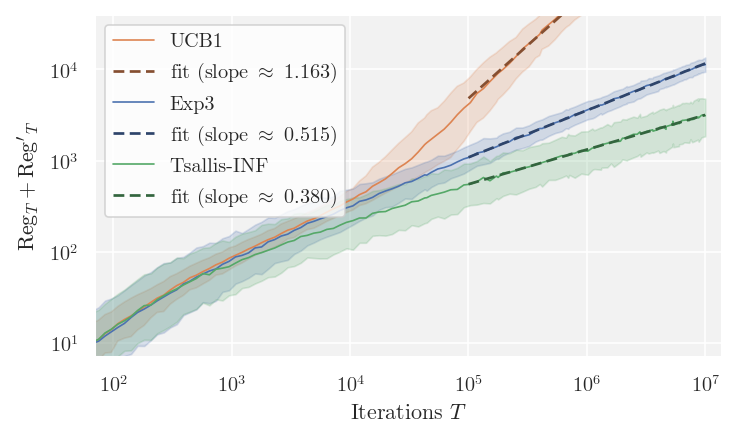

In [12]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(6 * 0.8, 3.5 * 0.8),
    layout="constrained",
    sharey=True,
    sharex=True,
    dpi=150,
)

palette = sns.color_palette()
palette_order = [1, 0, 2]
palette = [palette[i] for i in palette_order]

sns.lineplot(
    data=df,
    x="n_iter",
    y="regret",
    hue="Algorithm",
    palette=palette,
    ax=ax,
    estimator=lambda x: np.exp(np.mean(np.log(x))),
    errorbar=("pi", 80),
    linewidth=0.8,
)
for i, algo in enumerate(["UCB1", "Exp3", "Tsallis-INF"]):
    curve = curves[algo]
    x = choose_subset(np.arange(1, max_iter + 1), 1000)
    x = x[x >= 1e5]
    y = np.exp(curve["b"]) * x ** curve["k"]
    ax.plot(
        x,
        y,
        color=darker(palette[i], 0.6),
        label=f"fit (slope $\\approx$ {curve['k']:.3f})",
        linestyle=(0, (4, 2)),
        linewidth=1.3,
    )
ax.set_ylabel(r"$\mathrm{Reg}_T+\mathrm{Reg}'_T$")
ax.set_xlabel("Iterations $T$")
ax.set_yscale("log")
ax.set_xscale("log")
handles, labels = ax.get_legend_handles_labels()
handles, labels = [
    np.array(z).reshape(2, -1).T.flatten() for z in [handles, labels]
]
ax.legend(handles, labels, facecolor="white")
ax.set_xbound(lower=70, upper=1e7 * 1.4)
ax.set_ybound(lower=7, upper=4e4)

# set BG color to white
# fig.patch.set_facecolor('white')
# ax.set_facecolor('white')
plt.savefig(
    "regret_vs_iter.pdf",
    bbox_inches="tight",
    facecolor=fig.get_facecolor(),
    edgecolor="none",
)

### Discrepancy

The code is different yet equivalent to the description in
the preprint in the following ways:

- The paper assumes the feedback is in the range of $[-1, 1]$,
  while the code assumes the feedback is in the range of
  $[0, 1]$. In the code, everything is scaled accordingly,
  including the game matrix, the learning rate, and the regret.
- In the paper, $\mathrm{OPT}$ is defined as the sum of the
  inverse-square-gap over rows and columns. In the code, the
  `opt()` function only accounts for the row gap, so there
  is a factor of 2 discrepancy in the definition of $\mathrm{OPT}$.

The plotting script accounts for these discrepancies and scales
the axis accordingly, making the output figures consistent with
the paper.